# Regression of all intensities (both detected and not)
Regression has to be done by ion (mol+adduct), because we don't have a good way to combine intensities across adducts.

In [23]:
from pathlib import Path
import scipy.stats
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
plt.style.use('dark_background')

plots_dir = Path.cwd() / "../plots"
results_dir = Path.cwd() / "../results/regression_on_all"


In [24]:
filenames = {
    "fingerprints": "results_fingerprints_feat_selection.csv",
    "mol": "results_mol_feat_selection.csv",
    # "random_feat": "regr_results_random_feat.csv",
    # "no_feat": "regr_results_no_feat.csv",
}

INCLUDE_NOT_DETECTED_IN_SCORE = True

In [35]:
metric = "Spearman's R"

# compute Spearman's/Pearson's correlation and mean squared error for each matrix/polarity/regressor
scores = ["Spearman's R", 'S pval', "Pearson's R", 'P pval', 'RMSE', 'RMSE/std', 'non-zero obs']
models_results = pd.DataFrame()
model_metrics = pd.DataFrame(columns = ['train_setup', 'matrix', 'polarity', 'model_type', 'feat_sel_method', 'quantile'] + scores)
model_metrics_global = pd.DataFrame(columns = ['train_setup', 'model_type', 'feat_sel_method', 'quantile'] + scores)
counter = 0
counter_global = 0

for train_setup in filenames:
    result_filename = filenames[train_setup]
    loc_models_results = pd.read_csv(results_dir / result_filename, index_col = 0)
    loc_models_results = loc_models_results.rename(columns={'Matrix short': 'matrix',
                                                          'Polarity': 'polarity'})



    for (matrix, polarity, regressor, feat_sel_met, quantile), rows in loc_models_results.groupby(['matrix', 'polarity', 'regressor', 'feat_sel_method', 'feat_sel_quantile']):
        # remove zero intensity molecules if needed (optional)
        if not INCLUDE_NOT_DETECTED_IN_SCORE:
            rows = rows[rows['observed_value']!=0]

        spearman = scipy.stats.spearmanr(rows.observed_value, rows.prediction)
        pearson = scipy.stats.pearsonr(rows.observed_value, rows.prediction)
        mse = mean_squared_error(rows.observed_value, rows.prediction, squared = False)
        mse_std = mse / rows['observed_value'].std()
        model_metrics.loc[counter] = [train_setup, matrix, polarity, regressor, feat_sel_met, quantile,
                                      spearman[0], spearman[1],
                                           pearson[0], pearson[1], mse, mse_std,
                                           rows[rows['observed_value']!=0].shape[0]]
        counter += 1

    loc_models_results["train_setup"] = train_setup
    models_results = pd.concat([models_results, loc_models_results])

    # Compute global scores:
    for (regressor, feat_sel_met, quantile), rows in loc_models_results.groupby(['regressor', 'feat_sel_method', 'feat_sel_quantile']):
        # remove zero intensity molecules if needed (optional)
        if not INCLUDE_NOT_DETECTED_IN_SCORE:
            rows = rows[rows['observed_value']!=0]

        spearman = scipy.stats.spearmanr(rows.observed_value, rows.prediction)
        pearson = scipy.stats.pearsonr(rows.observed_value, rows.prediction)
        mse = mean_squared_error(rows.observed_value, rows.prediction, squared = False)
        mse_std = mse / rows['observed_value'].std()
        model_metrics_global.loc[counter_global] = [train_setup, regressor, feat_sel_met, quantile, spearman[0], spearman[1],
                                           pearson[0], pearson[1], mse, mse_std,
                                           rows[rows['observed_value']!=0].shape[0]]
        counter_global += 1

# Make the quantile integer numbers for better visualization
# model_metrics.quantile = model_metrics.quantile.as_numpy * 5

AttributeError: 'function' object has no attribute 'as_numpy'

Plot performances of different models, with different input features:

Index(['train_setup', 'matrix', 'polarity', 'model_type', 'feat_sel_method',
       'quantile', 'Spearman's R', 'S pval', 'Pearson's R', 'P pval', 'RMSE',
       'RMSE/std', 'non-zero obs'],
      dtype='object')

In [26]:
model_metrics.columns

Index(['train_setup', 'matrix', 'polarity', 'model_type', 'feat_sel_method',
       'quantile', 'Spearman's R', 'S pval', 'Pearson's R', 'P pval', 'RMSE',
       'RMSE/std', 'non-zero obs'],
      dtype='object')

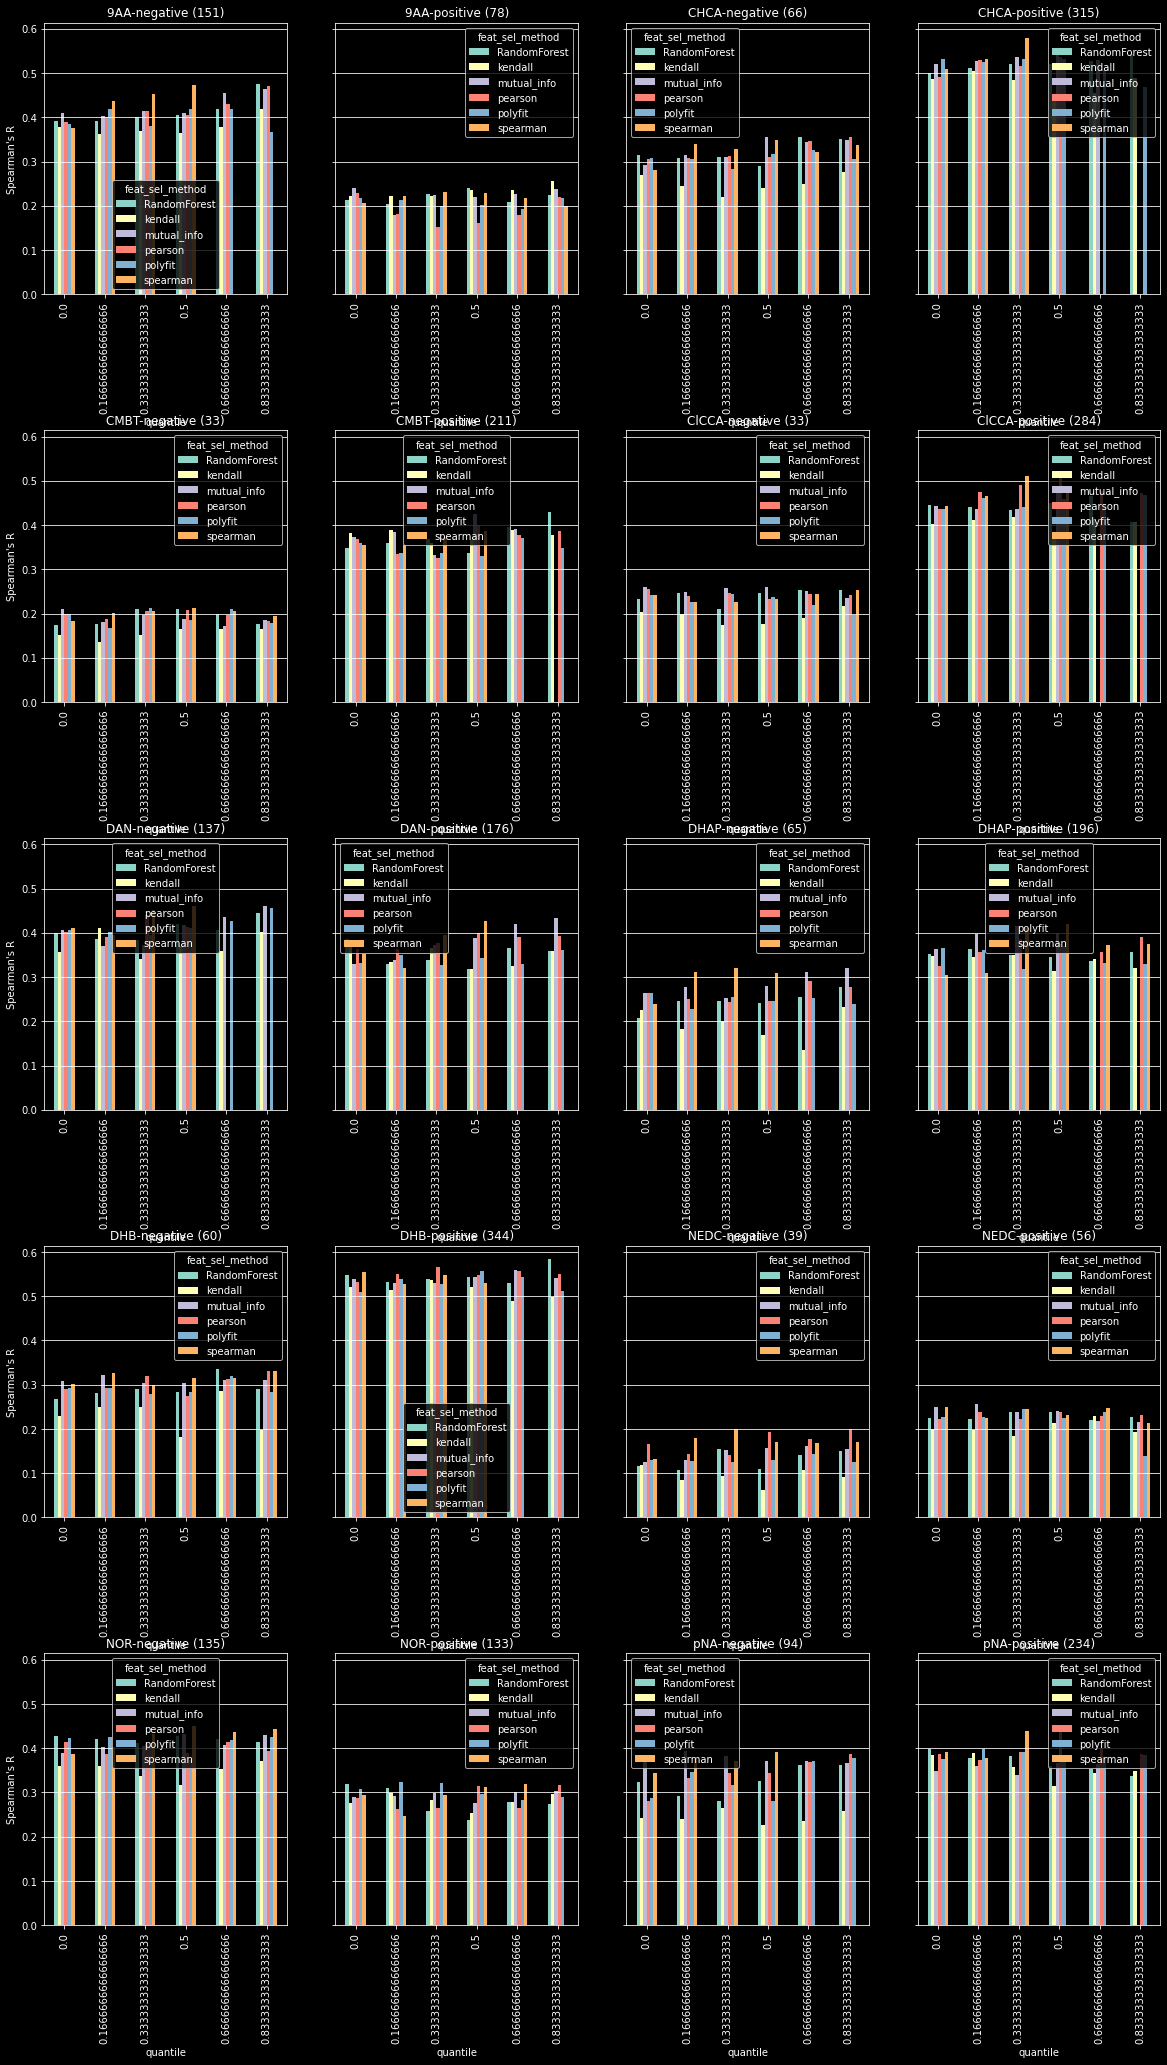

In [27]:
fig, axes = plt.subplots(ncols=4,nrows=5, sharey=True, figsize= (20, 35))
ax_list = axes.flat

metric = "Spearman's R"
#metric = "RMSE"

i = 0
for (matrix, polarity), rows in model_metrics.groupby(['matrix', 'polarity']):
    nb_obs = rows['non-zero obs'].drop_duplicates().values[0]
    rows = rows.set_index(['quantile', "feat_sel_method"], drop = True).sort_values( by = ["feat_sel_method", metric])
    rows = rows.unstack("feat_sel_method")
    rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity} ({nb_obs})")
    ax_list[i].set_ylabel(metric)
    ax_list[i].grid(axis='y')
    # TODO: position legend
    # if i != 0:
    #     ax_list[i].get_legend().set_visible(False)
    i+=1

plt.subplots_adjust(hspace=0.5)
plt.show()


For each matrix, get the max "Spearman's R" achieved, and compute difference between this max value and
 the value achieved by each model (compare bars of same colors, not across colors). MLP seems to be the best in all setups:

<AxesSubplot:xlabel='quantile'>

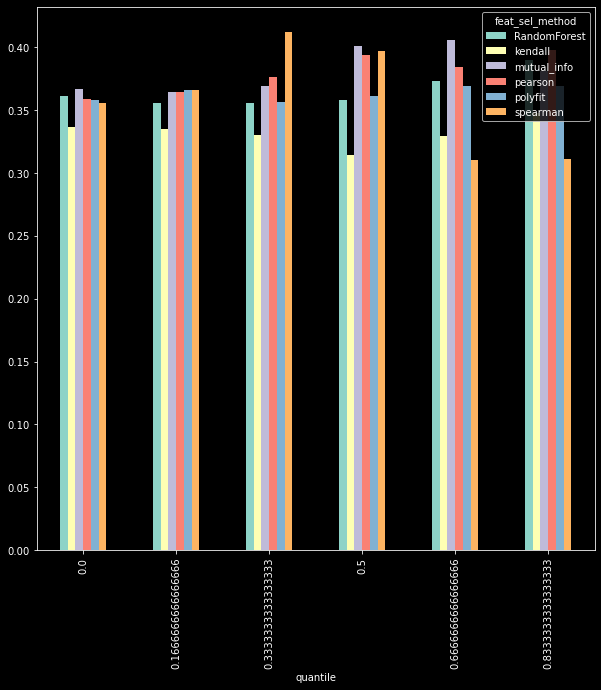

In [36]:
model_metrics_global.set_index(['quantile', "feat_sel_method"], drop=True)[metric].unstack("feat_sel_method").plot.bar(figsize=(10,10))

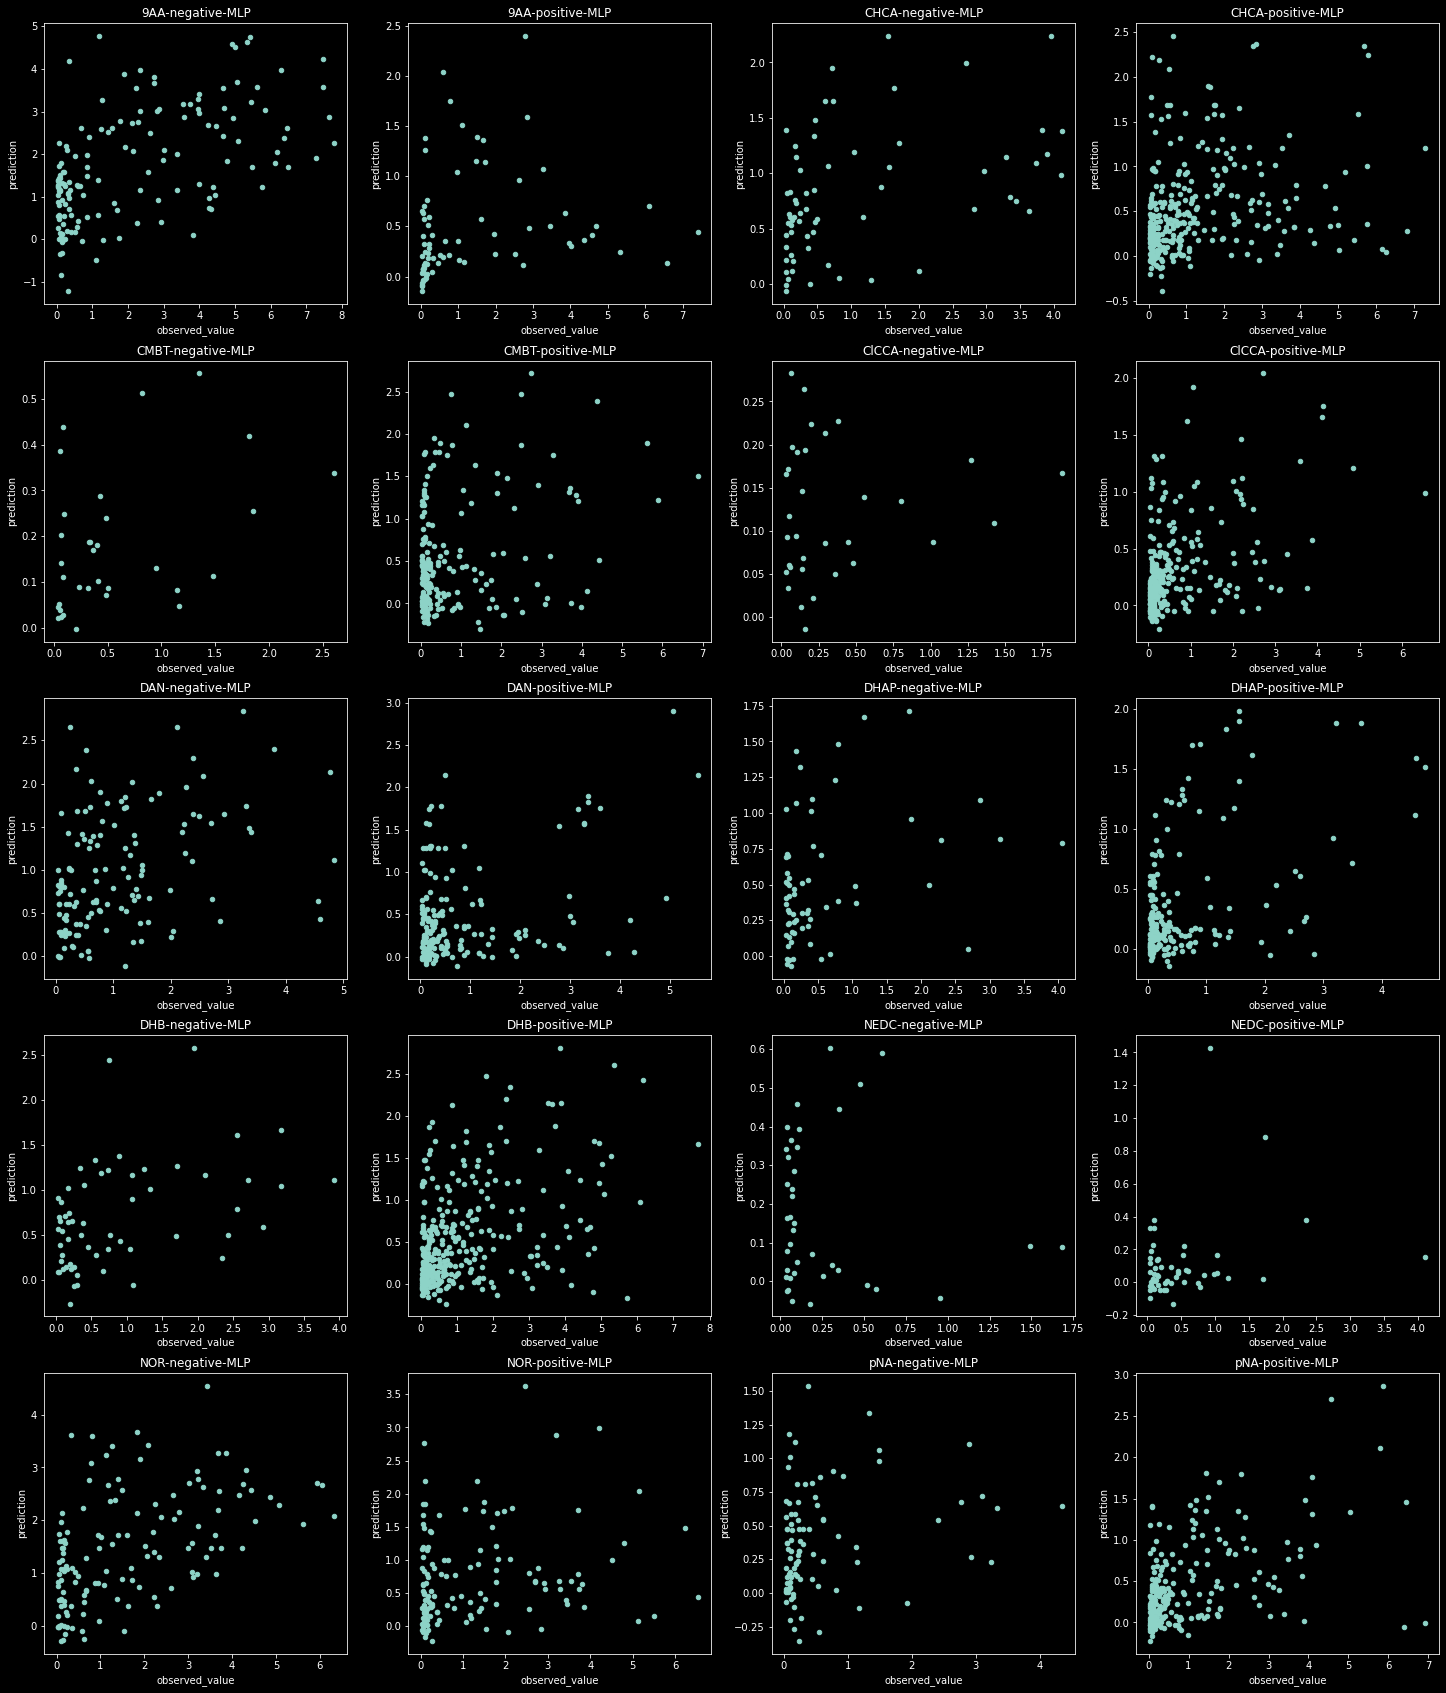

In [59]:
# fig, axes = plt.subplots(ncols=4,nrows=5, figsize= (25, 30))
# ax_list = axes.flat
#
# regressor = "MLP"
# train_setup = "all_feat"
#
# i = 0
# for (matrix, polarity), rows in models_results.groupby(['matrix', 'polarity']):
#     rows = rows[rows["train_setup"] == train_setup]
#     if not INCLUDE_NOT_DETECTED_IN_SCORE:
#         rows = rows[rows["observed_value"] > 0]
#     rows[rows.regressor == regressor].plot.scatter(x = 'observed_value', y= 'prediction',
#                                                    ax = ax_list[i], title=f"{matrix}-{polarity}-{regressor}")
#     i+=1
#
# plt.subplots_adjust(hspace=0.2, wspace=0.2)
# plt.show()